In [1]:
import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.infer import MCMC, NUTS
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.special import expit
import matplotlib.ticker as mtick

assert numpyro.__version__.startswith("0.8.0")

/usr/local/Caskroom/mambaforge/base/envs/numpyro/lib/python3.10/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/usr/local/Caskroom/mambaforge/base/envs/numpyro/lib/python3.10/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [3]:
df = df[df.date > '2021-10-01']
df = df[df.reason.isin(['N'])]
df['omi'] = df.lineage.apply(lambda x: int((x == 'BA.1')))
all = df.groupby(['sending_pc','date'])['omi'].count()
omi = df.groupby(['sending_pc','date'])['omi'].apply(lambda x: (x == 1).sum()).fillna(0).astype(int)
df_reshaped = pd.concat({'all': all, 'omi': omi}, axis=1).reset_index()
today = pd.Timestamp(str(dt.date.today()))
df_reshaped['days'] = (df_reshaped.date-today).dt.days
df_reshaped['sending_area'] = df_reshaped.sending_pc.apply(lambda x: int(x[0]))
lab_counts = df_reshaped[df_reshaped.date > '2021-12-01'].groupby('sending_pc')['all'].sum()
# df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['']))].copy()
df_filtered = df_reshaped[df_reshaped.sending_pc.isin(lab_counts[lab_counts>10].index) & (~df_reshaped.sending_pc.isin(['22767','70193','24106']))].copy()
le = LabelEncoder()
df_filtered['sending_pc_ID'] = le.fit_transform(df_filtered['sending_pc'].values)
omi_counts = df_filtered["omi"].values
total_counts = df_filtered["all"].values
sample_day = df_filtered["days"].values
sending_pc_ID = df_filtered['sending_pc_ID'].values
sending_area = df_filtered['sending_area'].values

In [6]:
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {k: LocScaleReparam(0) for k in ["mu_a", "a"]}

@numpyro.handlers.reparam(config=reparam_config)
def model3(sending_pc, sending_area, sample_day, total_counts,omi_counts=None):
    mu_a_mu = numpyro.sample("mu_a_mu", dist.Normal(0, 3.0))
    mu_a_sigma = numpyro.sample("mu_a_sigma", dist.HalfNormal(2.0))
    sigma_a = numpyro.sample("sigma_a", dist.HalfNormal(2.0))
    b = numpyro.sample("b", dist.Normal(0.2, 0.2))


    n_labs = len(np.unique(sending_pc))
    n_areas = len(np.unique(sending_area))

    sending_pc_to_area = pd.DataFrame({"sending_pc": sending_pc, "sending_area": sending_area}).groupby(['sending_pc']).sending_area.first().values

    with numpyro.plate("plate_i", n_areas):
        mu_a = numpyro.sample("mu_a", dist.Normal(mu_a_mu, mu_a_sigma))

    with numpyro.plate("plate_j", n_labs):
        a = numpyro.sample("a", dist.Normal(mu_a[sending_pc_to_area], sigma_a))

    logit_est = a[sending_pc] + b * sample_day


    with numpyro.plate("data", len(sending_pc)):
        numpyro.sample("obs", dist.BinomialLogits(logits=logit_est, total_count=total_counts), obs=omi_counts)


In [16]:
nuts_kernel = NUTS(model3)

mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sending_pc_ID, sending_area, sample_day, total_counts, omi_counts=omi_counts)

sample: 100%|██████████| 7000/7000 [01:02<00:00, 111.16it/s, 63 steps of size 6.75e-02. acc. prob=0.91] 


In [18]:
mcmc.print_summary()



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
   a_decentered[0]     -0.67      0.77     -0.62     -1.96      0.55   8043.87      1.00
   a_decentered[1]      0.78      0.53      0.80     -0.11      1.63   3991.40      1.00
   a_decentered[2]     -0.45      0.81     -0.42     -1.81      0.86   8093.45      1.00
   a_decentered[3]     -0.72      0.75     -0.66     -1.90      0.54   6755.85      1.00
   a_decentered[4]     -0.85      0.71     -0.79     -2.00      0.31   5738.39      1.00
   a_decentered[5]     -0.23      0.89     -0.20     -1.73      1.19   8574.04      1.00
   a_decentered[6]     -0.42      0.86     -0.38     -1.88      0.89   9553.92      1.00
   a_decentered[7]     -0.16      0.93     -0.14     -1.61      1.43  10191.96      1.00
   a_decentered[8]      1.16      0.40      1.15      0.52      1.82   2602.17      1.00
   a_decentered[9]     -0.47      0.79     -0.43     -1.71      0.90   7736.43      1.00
  a_decentered[10]  

,a,a_decentered,b,mu_a,mu_a_decentered,mu_a_mu,mu_a_sigma,sigma_a
mean,"[-3.4160953, -1.3635143, -3.1167548, -3.484635...","[-0.6661446, 0.7803943, -0.45130467, -0.716385...",0.188132,"[-2.4696639, -1.7803295, -0.18979938, -0.75223...","[-1.02861, -0.37723556, 1.0844355, 0.5756443, ...",-1.365784,1.145349,1.422113
std,"[1.1518968, 0.65074915, 1.224588, 1.134617, 1....","[0.7672599, 0.53048766, 0.8146255, 0.75270635,...",0.007647,"[0.54244345, 0.644516, 0.57985413, 0.5090421, ...","[0.58035284, 0.61533594, 0.59005773, 0.5601348...",0.453109,0.402943,0.212190
median,"[-3.3233128, -1.3087664, -3.0153356, -3.374070...","[-0.62219876, 0.800408, -0.41880432, -0.664886...",0.187986,"[-2.444089, -1.7414112, -0.18498114, -0.740653...","[-0.9941845, -0.36570814, 1.062507, 0.5564507,...",-1.357122,1.098947,1.406226
5.0%,"[-5.2724767, -2.362329, -5.0722466, -5.2188234...","[-1.9619161, -0.11183577, -1.810864, -1.901554...",0.175143,"[-3.3973954, -2.8256347, -1.1465428, -1.604320...","[-1.9467847, -1.3992505, 0.06933235, -0.341365...",-2.107638,0.545890,1.085044
95.0%,"[-1.6505406, -0.2367469, -1.0774994, -1.631559...","[0.5468079, 1.6345819, 0.8605161, 0.5399608, 0...",0.200492,"[-1.6110908, -0.7314773, 0.74773365, 0.0486072...","[-0.068631634, 0.6083939, 1.9859158, 1.4715371...",-0.629345,1.780603,1.766253
n_eff,"[7615.378546668466, 8295.38327432094, 7421.446...","[8043.868476299148, 3991.398431697043, 8093.45...",11313.579672,"[2569.8264521811175, 3379.5753978585058, 1469....","[3010.2544982723093, 3140.2090498435914, 2358....",1976.955784,1543.706054,1659.361642
r_hat,"[1.0001262, 0.9998923, 0.99995565, 0.9999538, ...","[1.000096, 0.9998103, 0.9999476, 0.9998923, 0....",0.999931,"[0.9998326, 0.99979997, 1.0001196, 1.0002834, ...","[0.9998074, 0.9998879, 0.9998515, 1.0000218, 0...",0.999834,0.999864,0.999974


In [9]:
mcmc.get_samples().keys()

dict_keys(['a', 'a_decentered', 'b', 'mu_a', 'mu_a_decentered', 'mu_a_mu', 'mu_a_sigma', 'sigma_a'])

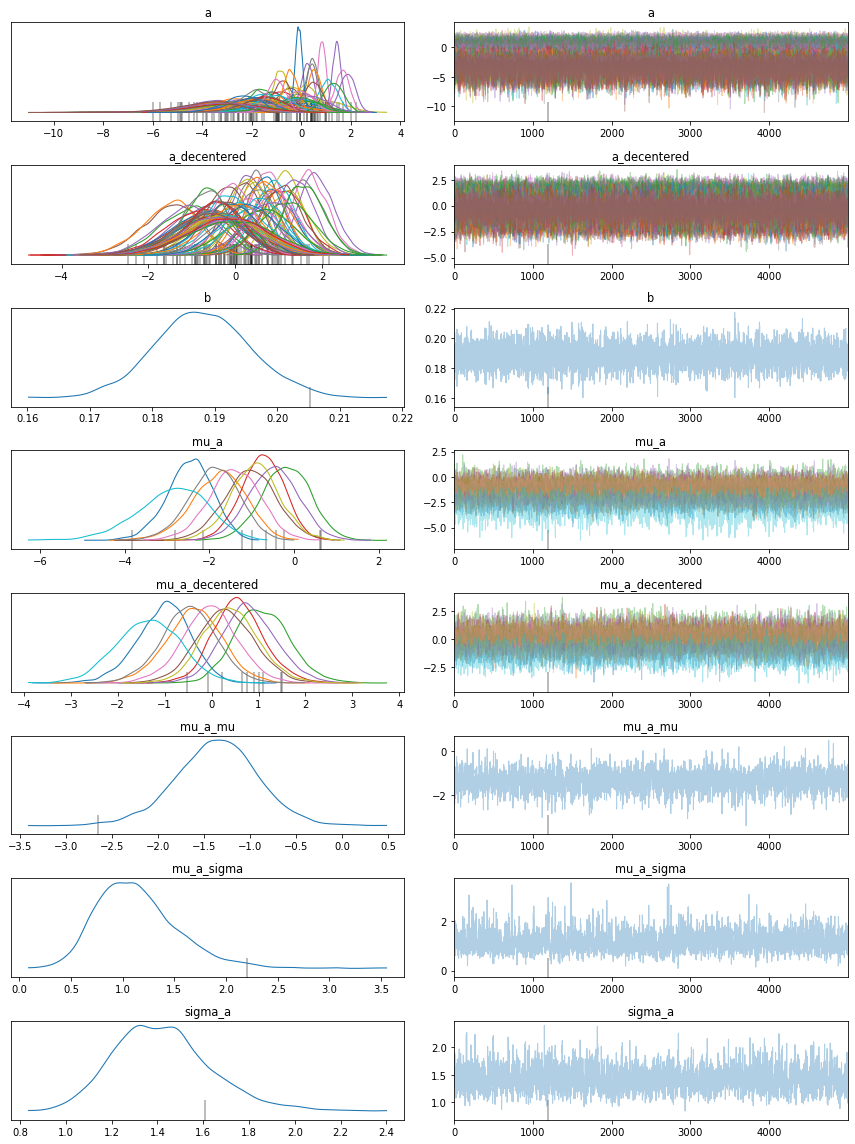

In [19]:
data = az.from_numpyro(mcmc)
az.plot_trace(data,compact=True)
plt.tight_layout()

In [20]:
s = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))

print(f"""
    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    {np.exp(s['b']['mean'])-1:.1%} mit 90%-Konfidenzintervall [{np.exp(s['b']['5.0%'])-1:.1%}, {np.exp(s['b']['95.0%'])-1:.1%}]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    {np.log(2)/np.log(1+s['b']['mean']):.2} Tage mit 90)%-Konfidenzintervall [{np.log(2)/np.log(1+s['b']['95.0%']):.2},{np.log(2)/np.log(1+s['b']['5.0%']):.2}]
    """)


    Relatives tägliches Wachstum von Omikron gegenüber Delta:
    20.7% mit 90%-Konfidenzintervall [19.1%, 22.2%]
    Relative Verdopplungszeit von Omikron gegenüber Delta:
    4.1 Tage mit 90)%-Konfidenzintervall [3.9,4.4]
    


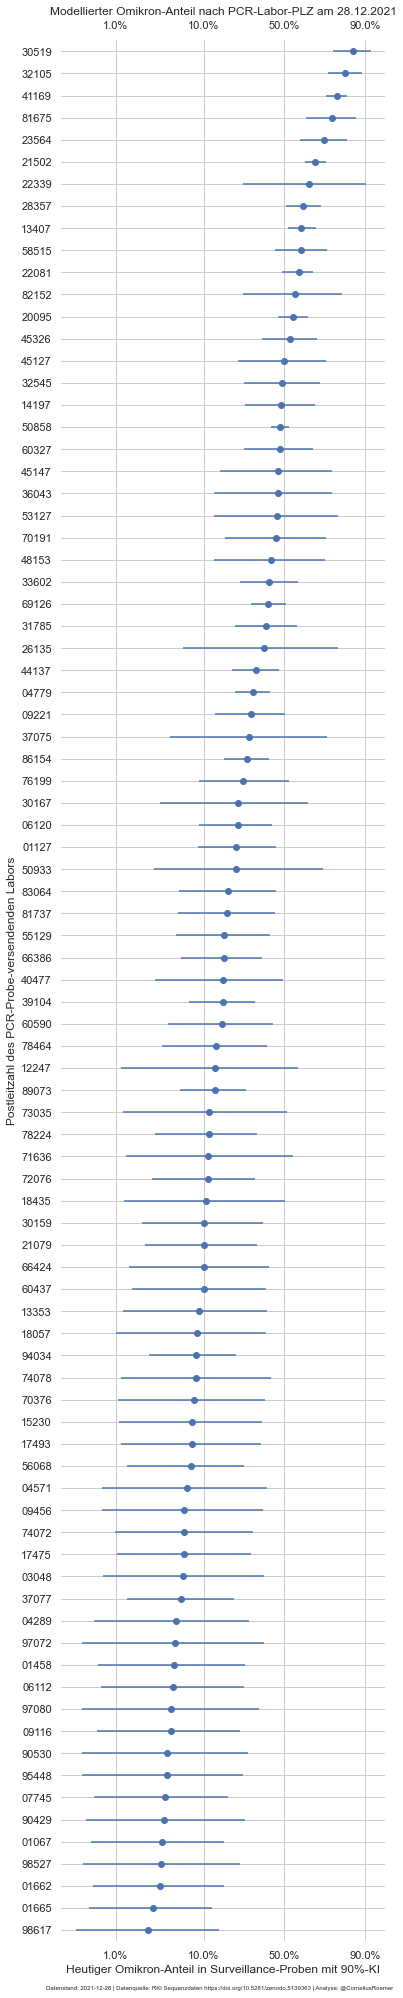

In [21]:
pdf = pd.DataFrame(s['a'])
pdf['plz'] = le.inverse_transform(pdf.index.values)
pdf.set_index('plz',inplace=True)
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(5,30)) 
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values,xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
ax.set(title=f'Modellierter Omikron-Anteil nach PCR-Labor-PLZ am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahl des PCR-Probe-versendenden Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.02)
fig.text(0.49, -0.003, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_pc.png",dpi=300,bbox_inches='tight',pad_inches=0.2)

Es gibt drei klare Ausreißer die entfernt wurden. Für mehr Details zu Outliern siehe das Notebook [Outlier Labs](outlier_labs.ipynb).

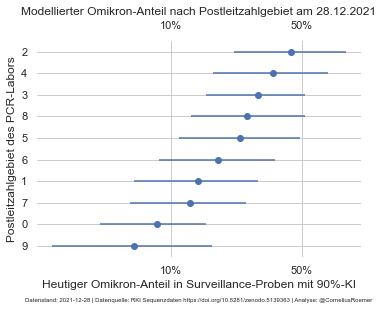

In [22]:
pdf = pd.DataFrame(s['mu_a'])
pdf.sort_values(by='median',inplace=True)
errors = ([expit(pdf['median'])-expit(pdf['5.0%']),expit(pdf['95.0%'])-expit(pdf['median'])])
fig, ax = plt.subplots(figsize=(5,4)) 
sns.set_theme(style="whitegrid")
ax.errorbar(x=expit(pdf['median'].values),y=pdf.index.values.astype(str),xerr=errors,linestyle='None',marker='o')
sns.despine(left=True, bottom=True)
ax.set(title='Title')
ax.set_ylim(-0.5,len(pdf)-0.5)
ax.set_xscale('logit')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=True)
ax.tick_params(axis='both', which='minor', labelbottom = False, bottom=False, top = False, labeltop=False)
ax.set(title=f'Modellierter Omikron-Anteil nach Postleitzahlgebiet am {today.strftime("%d.%m.%Y")}')
ax.set_ylabel("Postleitzahlgebiet des PCR-Labors")
ax.set_xlabel("Heutiger Omikron-Anteil in Surveillance-Proben mit 90%-KI")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.15)
fig.text(0.5, -0.01, f"Datenstand: {str(dt.date.today())} | Datenquelle: RKI Sequenzdaten https://doi.org/10.5281/zenodo.5139363 | Analyse: @CorneliusRoemer", size=6, va="bottom", ha="center")
fig.savefig("plots/omi_share_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)